# Device grouping

In [29]:
%pip install spacy spacy-transformers

# run in terminal
# %python -m spacy download en_core_web_lg
# python -m spacy download en_core_web_trf

Note: you may need to restart the kernel to use updated packages.


In [81]:
import spacy
import pandas as pd
from tqdm import tqdm
import numpy as np


In [78]:

synony_dict = {
    'refrigerator': 'fridge',
    'microwave oven': 'microwave',
    'washer dryer': 'washing machine',
    "television": "tv",
    "global active power" : "aggregate",
    "total" : "aggregate",
    "computer": "pc",
    "desktop" : "pc",
    "laptop" : "pc",
    "nespresso" : "coffee machine",
    "macbook" : "pc",
    # this is because we match substrings so "office pc" => "pc"
    "pc" : "pc",
    "running machine" : "treadmill",
}


appliances = []
data = pd.read_pickle("./Energy_graph/data/loadprofiles/merged_loadprofiles.pkl")
for k in data:
    if "LERTA" in k or "HUE" in k or "UCIML_1" in k:
        continue
    print("***************************************")
    for k2 in data[k]:
        print(k, k2)
        # convert to lower case and remove leading and trailing spaces
        k2 = k2.lower().strip()

        # handle tv with brand names
        if "tv" in k2:
            k2 = k2.split("-")[0]

        # replace _ with space
        if "_" in k2:
            k2 = k2.replace("_", " ")

        # ignore generic appliances
        if "appliances" in k2:
            continue
        # ignore 
        # replace synonyms
        for key, value in synony_dict.items():
            if key in k2:
                k2 = value
                break
        # ignore aggregate for now
        if "aggregate" in k2:
            continue
        appliances.append(k2)
# appliances=set(appliances)

# replace _ with space
appliances


***************************************
DEKN_2 circulation_pump
DEKN_2 dishwasher
DEKN_2 freezer
DEKN_2 aggregate
DEKN_2 washing_machine
***************************************
DEKN_4 dishwasher
DEKN_4 ev
DEKN_4 freezer
DEKN_4 aggregate
DEKN_4 heat_pump
DEKN_4 refrigerator
DEKN_4 washing_machine
***************************************
DEKN_1 dishwasher
DEKN_1 freezer
DEKN_1 aggregate
DEKN_1 heat_pump
DEKN_1 washing_machine
***************************************
DEKN_6 circulation_pump
DEKN_6 dishwasher
DEKN_6 freezer
DEKN_6 aggregate
DEKN_6 washing_machine
***************************************
DEKN_3 circulation_pump
DEKN_3 dishwasher
DEKN_3 freezer
DEKN_3 aggregate
DEKN_3 refrigerator
DEKN_3 washing_machine
***************************************
IAWE_1 aggregate
IAWE_1 fridge
IAWE_1 air conditioner
IAWE_1 washing machine
IAWE_1 computer
IAWE_1 clothes iron
IAWE_1 television
IAWE_1 wet appliance
IAWE_1 motor
***************************************
HEART_33 aggregate
HEART_33 fridge

['circulation pump',
 'dishwasher',
 'freezer',
 'washing machine',
 'dishwasher',
 'ev',
 'freezer',
 'heat pump',
 'fridge',
 'washing machine',
 'dishwasher',
 'freezer',
 'heat pump',
 'washing machine',
 'circulation pump',
 'dishwasher',
 'freezer',
 'washing machine',
 'circulation pump',
 'dishwasher',
 'freezer',
 'fridge',
 'washing machine',
 'fridge',
 'air conditioner',
 'washing machine',
 'pc',
 'clothes iron',
 'tv',
 'wet appliance',
 'motor',
 'fridge',
 'iron',
 'minioven',
 'tv',
 'router',
 'lamp',
 'monitor',
 'hair dryer',
 'watercooker',
 'heater',
 'fridge',
 'pc',
 'minioven',
 'tv',
 'router',
 'lamp',
 'pc',
 'watercooker',
 'radio',
 'monitor',
 'pc',
 'coffee machine',
 'electric hob',
 'core2 server',
 'treadmill',
 'oven',
 'steam iron',
 'toaster',
 '24 inch lcd bedroom',
 'network attached storage',
 'stereo speakers bedroom',
 'primary tv',
 'washing machine',
 'microwave',
 'kettle',
 'home theatre amp',
 'ps4',
 'hairdryer',
 'pc',
 '24 inch lcd',
 

In [75]:


# Load spaCy model
nlp = spacy.load('en_core_web_lg')


# Convert list of appliances to a list of spaCy objects and filter out those without vectors
appliances_nlp = [(i, nlp(appliance)) for i, appliance in enumerate(appliances) if nlp(appliance).has_vector]

# Create a similarity matrix
similarity_matrix = np.zeros((len(appliances_nlp), len(appliances_nlp)))

for idx1 in tqdm(range(len(appliances_nlp))):
    for idx2 in range(len(appliances_nlp)):
        if idx2 > idx1:  # Compute only upper triangle
            similarity_matrix[idx1, idx2] = appliances_nlp[idx1][1].similarity(appliances_nlp[idx2][1])

# Make the matrix symmetric
similarity_matrix = similarity_matrix + similarity_matrix.T - np.diag(similarity_matrix.diagonal())
# works pretty well with 0.8
threshold = 0.9
grouped_appliances = {}
visited = set()

for idx1, (i, appliance) in enumerate(appliances_nlp):
    if i in visited:
        continue

    # Find indices of appliances that are similar to the current appliance
    similar_indices = np.where(similarity_matrix[idx1] > threshold)[0]

    # Group those appliances together
    grouped_appliances[appliance] = [appliances[appliances_nlp[idx][0]] for idx in similar_indices]

    # Mark the similar appliances as visited
    visited.update([appliances_nlp[idx][0] for idx in similar_indices])



100%|██████████| 691/691 [00:00<00:00, 880.27it/s]


In [80]:
for appliance in grouped_appliances:
    grouped_appliances[appliance] = set(grouped_appliances[appliance])


# print this to file
with open('./Energy_graph/device_grouping.txt', 'w') as f:
    for appliance in grouped_appliances:
        f.write(f'{appliance}: {grouped_appliances[appliance]}\n')
grouped_appliances

{circulation pump: {'circulation pump'},
 dishwasher: {'dishwasher'},
 freezer: {'freezer', 'fridge freezer'},
 washing machine: {'washing machine', 'washing machine microwave breadmaker'},
 ev: set(),
 heat pump: {'heat pump'},
 fridge: {'fridge', 'fridge freezer'},
 air conditioner: {'air conditioner',
  'air conditioning',
  'air exchanger',
  'air exhaust'},
 pc: {'pc'},
 clothes iron: set(),
 tv: {'primary tv', 'tv', 'tv dvd digibox lamp'},
 wet appliance: set(),
 motor: set(),
 iron: {'iron', 'soldering iron'},
 router: {'adsl router', 'router'},
 lamp: {'lamp', 'utilityrm lamp'},
 monitor: {'monitor'},
 hair dryer: {'hair dryer'},
 heater: {'electric heater'},
 radio: set(),
 coffee machine: {'coffee machine'},
 electric hob: set(),
 core2 server: {'server', 'server hdd'},
 treadmill: {'treadmill'},
 oven: {'oven'},
 steam iron: set(),
 toaster: {'toaster'},
 24 inch lcd bedroom: {'24 inch lcd'},
 network attached storage: set(),
 stereo speakers bedroom: set(),
 microwave: {'mi

# Class balances

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from collections import defaultdict
import os
from tqdm import tqdm
import numpy as np

In [ ]:
data = pd.read_pickle("./Energy_graph/data/processed/labelled/REDD.pkl")


data["REDD_1"]

In [17]:
df = pd.DataFrame()
for d,v in tqdm(data["REDD_1"].items()):
    v.columns = [d]
    df = pd.concat([df,v ], axis=1)

df.fillna(0, inplace=True)
df[df>0] = 1 
df[df<=0] = 0

100%|██████████| 10/10 [00:00<00:00, 50.89it/s]


In [14]:
# set the threshold to 0.0001
threshold = 0.0001
time_window = "6H"

cumulative_appearances = pd.Series(dtype='float64')

for house in data:
    df = pd.DataFrame()
    for device in data[house]:
        if device == 'aggregate':
            continue
        df = pd.concat([df, data[house][device]], axis=1)
    df[df > threshold] = 1
    df[df <= threshold] = 0
    
    # Resample the DataFrame to 6-hour windows and sum the values
    resampled_df = df.resample(time_window).sum()

    # Check the appearance of each device in the windows
    appearances = (resampled_df > 0).sum()
    
    # Aggregate the appearances for the same devices across houses
    cumulative_appearances = cumulative_appearances.add(appearances, fill_value=0)


In [16]:
cumulative_appearances

 bread-maker                    319.0
 chest freezer                 2266.0
 chest freezer (in garage)     2046.0
 combination microwave         1359.0
 computer                      2014.0
 computer site                11118.0
 dehumidifier/heater            513.0
 desktop computer              1677.0
 dishwasher                    7890.0
 dryer                          745.0
 electric heater               2344.0
 electric heater (1)?            67.0
 electric heater (2)            717.0
 food mixer                      24.0
 freezer                       9207.0
 freezer (garage)              3922.0
 freezer (utility room)        1980.0
 freezer(garage)               1676.0
 fridge                       11341.0
 fridge & freezer              1772.0
 fridge(garage)                1646.0
 fridge-freezer               23421.0
 fridge-freezer (1)            1916.0
 fridge-freezer (2)            1584.0
 hi-fi                         3257.0
 kenwood kmix                   183.0
 kettle     

In [24]:

# Load spaCy model
nlp = spacy.load('en_core_web_trf')

# Preprocess device names
def preprocess_device_name(device_name):
    return ''.join([char for char in device_name if char.isalpha() or char.isspace()]).strip()

# Create a mapping from original device name to its processed form and spaCy tokens
processed_names = {name: preprocess_device_name(name) for name in cumulative_appearances.index}
processed_tokens = {name: nlp(processed_name) for name, processed_name in processed_names.items()}

# Group devices using spaCy similarity
threshold = 0.6
grouped_values = defaultdict(float)

for original_name, value in cumulative_appearances.items():
    processed_name = processed_names[original_name]
    processed_token = processed_tokens[original_name]

    added = False
    for grouped_name, grouped_token in processed_tokens.items():
        if processed_token.similarity(grouped_token) > threshold:
            grouped_values[grouped_name] += value
            added = True
            break

    if not added:
        grouped_values[processed_name] += value
        processed_tokens[original_name] = processed_token

# Convert the defaultdict back to a pandas series
grouped_series = pd.Series(grouped_values)


/tmp/ipykernel_1155/3799702240.py:22: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  if processed_token.similarity(grouped_token) > threshold:
/tmp/ipykernel_1155/3799702240.py:22: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  if processed_token.similarity(grouped_token) > threshold:


plot the data

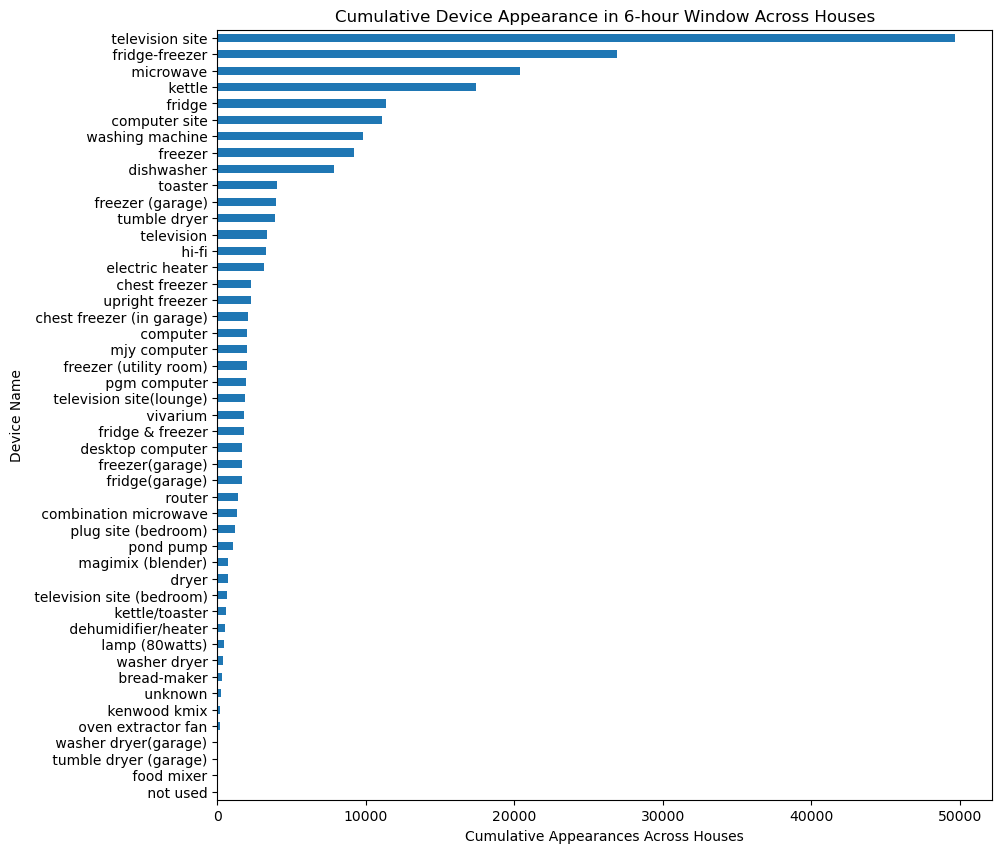

In [25]:

# Now, plot the aggregated appearances for all houses
grouped_series.sort_values().plot(kind='barh', figsize=(10, 10))
plt.xlabel('Cumulative Appearances Across Houses')
plt.ylabel('Device Name')
plt.title('Cumulative Device Appearance in 6-hour Window Across Houses')
plt.show()







All the datasets class balances

In [4]:
# convert the data into a dataframe with the devices as columns
def process_dict(data : dict):
    threshold = 0.0001
    time_window = '6H'
    
    cumulative_appearances = pd.Series(dtype='float64')
    df = pd.DataFrame()
    for device in data[house]:
        # skip aggregate as we are only interested in the individual devices
        if device == 'aggregate':
            continue
        curr_df = data[house][device]
        curr_df.columns = [device]
        df = pd.concat([df, curr_df], axis=1)
    df.fillna(0, inplace=True)
    # resample to 1 hour so we can use the same treshold for all datasets
    df = df.resample('1H').sum()
    df[df > threshold] = 1
    df[df <= threshold] = 0

    
    # Resample the DataFrame to 6-hour windows and sum the values
    resampled_df = df.resample(time_window).sum()

    # Check the appearance of each device in the windows
    appearances = (resampled_df > 0).sum()
    
    # Aggregate the appearances for the same devices across houses
    cumulative_appearances = cumulative_appearances.add(appearances, fill_value=0)
    
    return cumulative_appearances 

def get_device_names(data : dict):
    devices = []
    for house in data:
        for device in data[house]:
            if device == 'aggregate':
                continue
            devices.append(device)

    return set(devices)

def create_mapping(appliances : set):
    synonym_dict = {
    'refrigerator': 'fridge',
    'microwave oven': 'microwave',
    'washer dryer': 'washing machine',
    "television": "tv",
    "global active power" : "aggregate",
    "total" : "aggregate",
    "computer": "pc",
    "desktop" : "pc",
    "laptop" : "pc",
    "nespresso" : "coffee machine",
    "macbook" : "pc",
    # this is because we match substrings so "office pc" => "pc"
    "pc" : "pc",
    "running machine" : "treadmill",
    }


    # Load spaCy model
    nlp = spacy.load('en_core_web_lg')

    # processed appliance labels
    labels_processed = []

    for a in list(appliances):
        a = a.lower().strip()
        # handle tv with brand names
        if "tv" in a:
            a = a.split("-")[0]

        # replace _ with space
        if "_" in a:
            a = a.replace("_", " ")
        
        # remove room info
        if "(" in a:
            a = a.split("(")[0]

        # ignore generic appliances
        if "appliances" in a:
            continue
        # ignore 
        # replace synonyms
        for key, value in synonym_dict.items():
            if key in a:
                a = value
                break
        # ignore aggregate for now
        if "aggregate" in a:
            continue

        labels_processed.append(a)

    

    # Convert list of appliances to a list of spaCy objects and filter out those without vectors
    appliances_nlp = [(i, nlp(appliance)) for i, appliance in enumerate(labels_processed) if nlp(appliance).has_vector]

    # Create a similarity matrix
    similarity_matrix = np.zeros((len(appliances_nlp), len(appliances_nlp)))

    for idx1 in range(len(appliances_nlp)):
        for idx2 in range(len(appliances_nlp)):
            if idx2 > idx1:  # Compute only upper triangle
                similarity_matrix[idx1, idx2] = appliances_nlp[idx1][1].similarity(appliances_nlp[idx2][1])

    # Make the matrix symmetric
    similarity_matrix = similarity_matrix + similarity_matrix.T - np.diag(similarity_matrix.diagonal())

    # works pretty well with 0.8 aswell
    threshold = 0.9
    grouped_appliances = {}
    visited = set()

    for idx1, (i, appliance) in enumerate(appliances_nlp):
        if i in visited:
            continue

        # Find indices of appliances that are similar to the current appliance
        similar_indices = np.where(similarity_matrix[idx1] > threshold)[0]

        # Group those appliances together
        grouped_appliances[appliance] = [labels_processed[appliances_nlp[idx][0]] for idx in similar_indices]

        # Mark the similar appliances as visited
        visited.update([appliances_nlp[idx][0] for idx in similar_indices])


    # remove duplicates
    for key, value in grouped_appliances.items():
        grouped_appliances[key] = list(set(value))

    # create mapping where each value maps to its key
    mapping = {}
    for key, value in grouped_appliances.items():
        for v in value:
            mapping[v] = key


    return mapping




In [6]:
devices = set()
appearances = []
for dataset in tqdm(os.listdir("./Energy_graph/data/processed/labelled/")):
    # skip dataset without devices
    if "HUE" in dataset or "LERTA" in dataset or "UCIML" in dataset:
        continue
    print(dataset)
    # load dataset  
    data_dict = pd.read_pickle("./Energy_graph/data/processed/labelled/" + dataset)
    devices.update(get_device_names(data_dict))
    for house in data_dict:
        print(house)
        # convert to dataframe
        data = process_dict(data_dict)
        appearances.append(data)
        

    


  0%|          | 0/16 [00:00<?, ?it/s]

DRED.pkl


  6%|▋         | 1/16 [00:04<01:14,  4.97s/it]

DEDDIAG.pkl


 19%|█▉        | 3/16 [00:45<03:32, 16.33s/it]

IAWE.pkl


 25%|██▌       | 4/16 [00:52<02:36, 13.06s/it]

ENERTALK.pkl


 25%|██▌       | 4/16 [01:37<04:52, 24.35s/it]


KeyboardInterrupt: 

In [34]:

mapping = create_mapping(devices)

    

In [35]:
mapping

{'fridge freezer': fridge,
 'freezer': freezer,
 'freezer ': freezer,
 'dryer': dryer,
 'tumble dryer ': dryer,
 'tumble dryer': dryer,
 'tv': tv,
 'primary tv': tv,
 'tv dvd digibox lamp': livingroom lamp tv,
 'pc': pc,
 'treadmill': treadmill,
 'office lamp3': hifi office,
 'lcd office': hifi office,
 'office lamp1': hifi office,
 'office lamp2': hifi office,
 'air exhaust': air exchanger,
 'air conditioning': air handling unit,
 'air conditioner': air exchanger,
 'washing machine ': washing machine,
 'washing machine': washing machine,
 'washing machine microwave breadmaker': washing machine,
 '24 inch lcd': 24 inch lcd bedroom,
 'heater': electric heater,
 'electric furnace': electric heater,
 'electric heater ': electric heater,
 'electric heater': electric heater,
 'samsung charger': ipad charger,
 'kitchen outlet #3': lights bedroom #1 and #3,
 'heat bedroom #2': lights bedroom #1 and #3,
 'office outlet #3': lights bedroom #1 and #3,
 'kitchen outlet #2': lights bedroom #1 and 